# Publication Plots for the Sherrington-Kirkpatrick Model

In [1]:
using HDF5, Printf
using LsqFit, Measurements

using PyCall, PyPlot
np = pyimport("numpy")
h5py = pyimport("h5py")
PyPlot.plt.style.use("../paper.mplstyle")

In [2]:
# path to folder with the h5 files
PATH_DB = "/home/lappet/Dropbox/MidnightRambler/Mean_Field_AOA/Figures/Data/SK_model/Averaged_MF_energy/"
PATH = "../data/SK_model/"

"../data/SK_model/"

## Plots

### Average Energy

#### Tim

In [3]:
E_0 = -0.763
p = 1000
num_instances = 10000
seed = 137

E_star_data = []
E_star_std_data = []
# for num in vcat([10 + k * 5 for k in 0:22], [200])
for num in vcat([10 + k * 10 for k in 0:11], [150, 180, 200])
    N = num
    new_file = "SK_model_" * "p_" * string(p) * "_N_" * string(N) * "_num_inst_" * string(num_instances) * "_seed_" * string(seed) * "_moments.h5"
    data_file = h5open(PATH * new_file, "r")
    println(new_file)
    E_star = read(data_file, "E_star")[1]
    E_star_squared = read(data_file, "E_star_squared")[1]
    push!(E_star_data, E_star / N - E_0)
    push!(E_star_std_data, sqrt.(E_star_squared - E_star^2) / N)
end

SK_model_p_1000_N_10_num_inst_10000_seed_137_moments.h5
SK_model_p_1000_N_20_num_inst_10000_seed_137_moments.h5
SK_model_p_1000_N_30_num_inst_10000_seed_137_moments.h5
SK_model_p_1000_N_40_num_inst_10000_seed_137_moments.h5
SK_model_p_1000_N_50_num_inst_10000_seed_137_moments.h5
SK_model_p_1000_N_60_num_inst_10000_seed_137_moments.h5
SK_model_p_1000_N_70_num_inst_10000_seed_137_moments.h5
SK_model_p_1000_N_80_num_inst_10000_seed_137_moments.h5
SK_model_p_1000_N_90_num_inst_10000_seed_137_moments.h5
SK_model_p_1000_N_100_num_inst_10000_seed_137_moments.h5
SK_model_p_1000_N_110_num_inst_10000_seed_137_moments.h5
SK_model_p_1000_N_120_num_inst_10000_seed_137_moments.h5
SK_model_p_1000_N_150_num_inst_10000_seed_137_moments.h5
SK_model_p_1000_N_180_num_inst_10000_seed_137_moments.h5
SK_model_p_1000_N_200_num_inst_10000_seed_137_moments.h5


#### Dima

In [4]:
file = "SK_model_Averaged_MF_Energy.h5"

"SK_model_Averaged_MF_Energy.h5"

In [5]:
filename = PATH_DB * file
h5file = h5open(filename, "r")
MF_optimum = read(h5file, "MF_optimum")
MF_sigma = read(h5file, "MF_sigma");

In [6]:
# N = vcat([10 + k * 5 for k in 0:22], [200])
N = vcat([10 + k * 10 for k in 0:11], [150, 180, 200])
E = MF_optimum[2, :] # Energy expectation
σ = MF_sigma[2, :]; # Energy std. deviation

In [7]:
m(x, p) = p[1] .+ p[2] .* x
p0 = [0., -0.5]

2-element Vector{Float64}:
  0.0
 -0.5

In [8]:
fit_E = curve_fit(m, log.(N), log.(E_star_data), p0)    
println(fit_E.resid .|> abs |> sum)    
println(fit_E.param)

0.07377249394718133
[-0.38233477812073136, -0.6080392270372236]


In [9]:
fit_σ = curve_fit(m, log.(N), log.((E_star_std_data)), p0)    
println(fit_σ.resid .|> abs |> sum)    
println(fit_σ.param)

0.16947907046966915
[-0.7055661954677702, -0.6822950140192202]


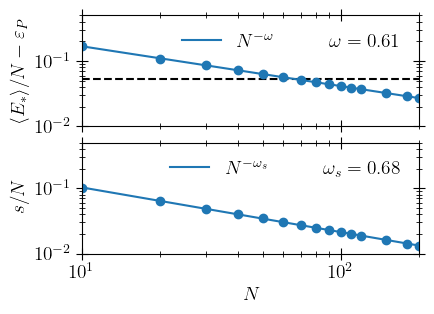

In [10]:
fig = figure(figsize=(4.2, 3))
ax = subplot(211)
# ax.loglog(MF_optimum[1, :], E, "o")
axhline(0.053, c="k", ls="--")
ax.loglog(N, E_star_data, "o")
ax.loglog(N, map(x -> m(x, [fit_E.param[1], fit_E.param[2]]), log.(N)) .|> exp, "-C0", label="\$N^{-\\omega}\$")
ax.loglog([], [], lw=0, label=@sprintf("\$ \\omega = %.2f \$", fit_E.param[2] |> abs))
ax.set_ylabel("\$\\langle E_*\\rangle / N - \\varepsilon_P\$")
ax.set_xticklabels([])
ax.set_xlim(10, 200)
ax.set_ylim(0.01, 0.5)
ax.legend(ncol=2, columnspacing=0.1)

ax = subplot(212)
# ax.loglog(MF_optimum[1, :], σ, "s")
ax.loglog(N, E_star_std_data, "o")
ax.loglog(N, map(x -> m(x, [fit_σ.param[1], fit_σ.param[2]]), log.(N)) .|> exp, "-C0", label="\$N^{-\\omega_s}\$")
ax.loglog([], [], lw=0, label=@sprintf("\$ \\omega_s = %.2f \$", fit_σ.param[2] |> abs))
# ax.fill_between(N, E .- σ, E .+ σ, alpha=0.25)
# ax.set_xlim(N[1], N[end])  
# ax.set_xticks([k for k in 4:2:20])
ax.set_ylim(0.01, 0.5)
ax.set_xlim(10, 200)
ax.set_xlabel("\$N\$")
ax.set_ylabel("\$ s / N\$")
ax.legend(ncol=2, columnspacing=0.1)

tight_layout(pad=0.15, w_pad=0.0, h_pad=0.0)
savefig(PATH_DB * "Fig1.pdf", dpi=300)

### Histograms

In [11]:
using Statistics, Distributions

In [12]:
N = 10 # 
N = 15 
N = 20

20

#### Mean-field statistics

In [13]:
new_file = "SK_model_" * "p_" * string(p) * "_N_" * string(N) * "_num_inst_" * string(num_instances) * "_seed_" * string(seed) * "_hist_stats.h5"
data_file = h5open(PATH * new_file, "r")
all_E_stars = read(data_file, "all_E_stars")
counts, bins = np.histogram((all_E_stars .- mean(all_E_stars)) ./ sqrt(var(all_E_stars)), bins=20)

([4, 6, 15, 36, 51, 87, 173, 300, 519, 784, 1078, 1336, 1454, 1444, 1159, 834, 458, 186, 58, 18], [-4.471172007188427, -4.105958919616271, -3.740745832044115, -3.3755327444719594, -3.0103196568998034, -2.6451065693276474, -2.279893481755492, -1.914680394183336, -1.54946730661118, -1.184254219039024  …  -0.45382804389471243, -0.08861495632255689, 0.27659813124959953, 0.6418112188217551, 1.0070243063939115, 1.372237393966067, 1.7374504815382226, 2.102663569110379, 2.4678766566825345, 2.8330897442546905])

#### Exact data

In [14]:
new_file = "SK_model" * "_N_" * string(N) * "_num_inst_" * string(num_instances) * "_seed_" * string(seed) * "_exact.h5"
data_file = h5open(PATH * new_file, "r")
all_E_0s = []
for i in 1:num_instances
    E_0 = read(data_file, "set_" * string(i) * "/E_0")
    push!(all_E_0s, E_0)
end

counts_0, bins_0 = np.histogram((all_E_0s .- mean(all_E_0s)) ./ sqrt(var(all_E_0s)), bins=20)

([4, 6, 15, 39, 48, 94, 175, 324, 543, 850, 1152, 1418, 1582, 1461, 1109, 706, 344, 95, 30, 5], [-4.583461372387455, -4.2017574465124765, -3.8200535206374973, -3.438349594762519, -3.05664566888754, -2.6749417430125613, -2.293237817137583, -1.911533891262604, -1.5298299653876253, -1.1481260395126465  …  -0.3847181877626893, -0.003014261887710923, 0.37868966398726833, 0.7603935898622467, 1.142097515737226, 1.5238014416122043, 1.9055053674871827, 2.287209293362162, 2.6689132192371403, 3.0506171451121187])

#### Plots

In [15]:
g_m(x, m, u, v, w) = w .* exp.(m .* (x .- u) ./ v - m .* exp.((x .- u) ./ v))
g_m(x, p) = g_m(x, p...);

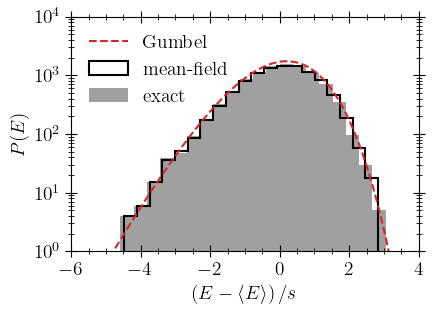

In [16]:
X = np.linspace(-6, 5, 101)

fig = figure(figsize=(4.2, 3))
ax = subplot(111)
# hist(bins_0[1:end-1], bins_0, weights=(counts_0 ./ num_instances), alpha=0.5, label="exact")
# hist(bins[1:end-1], bins, weights=(counts ./ num_instances), alpha=0.5, label="mean-field")
# plot(X, map(x -> pdf(Gumbel(gumbel_fit_0...), -x), X))
# plot(X, map(x -> g_m(x, 6, 0, 2, 100), X))
# plot(X, map(x -> num_instances .* pdf(Gumbel(gumbel_fit_0...), -x), X) .|> log)
plot(X, map(x -> g_m(x, 6, 0.2, 2.35, 7e5), X), label="Gumbel", "--C3", lw=1.5)
hist(bins[1:end-1], bins, weights=(counts), alpha=1.0, lw=1.5, color="k", label="mean-field", histtype="step")
hist(bins_0[1:end-1], bins_0, weights=(counts_0), alpha=0.75, label="exact", color="grey")#, histtype="step")#, hatch="x", edgecolor="w")
# ax.fill_between(bins_0[1:end-1], log.(counts_0), lw=10, step="post", alpha=0.5)
legend(loc="upper left", ncol=1)
ax.set_yscale("log")
ax.set_xlim(-6, 4)
# ax.set_ylim(0., 12)
ax.set_ylim(1e0, 1e4)
ax.set_xticks([-6 + 2k for k in 0:5])
# ax.set_yticks([10^k for k in 0:4])
ax.set_xlabel("\$\\left(E - \\langle E \\rangle\\right) / s\$")
ax.set_ylabel("\$ P(E)\$")
# plot(bins,  map(x -> 0.3 * pdf(Gumbel(-0.4, 0.7 * sqrt(var(all_E_0s))), -x) , bins))
tight_layout(pad=0.15, w_pad=0.0, h_pad=0.0)
# savefig(PATH_DB * "Fig2.pdf", dpi=300)

#### Tails

In [17]:
tail_counts, tail_bins = np.histogram((all_E_stars .- all_E_0s) ./ abs(mean(all_E_0s)), bins=100)

([7176, 213, 190, 172, 170, 141, 165, 137, 113, 120  …  0, 0, 0, 1, 0, 0, 0, 0, 0, 1], [-5.378133072317385e-16, 0.002931108103588243, 0.005862216207177024, 0.008793324310765804, 0.011724432414354585, 0.014655540517943367, 0.017586648621532145, 0.020517756725120927, 0.02344886482870971, 0.02637997293229849  …  0.2667308374265785, 0.26966194553016726, 0.2725930536337561, 0.27552416173734484, 0.2784552698409336, 0.28138637794452237, 0.2843174860481112, 0.28724859415169995, 0.2901797022552887, 0.29311081035887754])

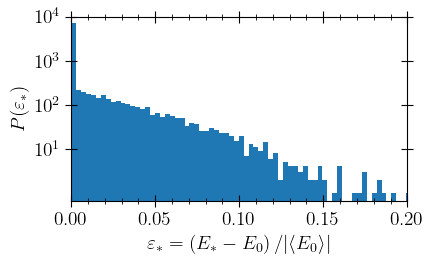

In [18]:
fig = figure(figsize=(4.2, 2.5))
ax = subplot(111)
hist(tail_bins[1:end-1], tail_bins, weights=tail_counts, alpha=1.0, lw=1.5, color="C0")
ax.set_xlabel("\$\\varepsilon_* = \\left(E_* - E_0\\right) / |\\langle E_0 \\rangle| \$")
ax.set_ylabel("\$ P(\\varepsilon_*)\$")
ax.set_yscale("log")
# axvline(cutoff, c="C3", label="cutoff")
# legend(loc="upper right", ncol=2)
ax.set_xlim(0, 0.2)
ax.set_ylim(0., 1e4)
ax.set_yticks([1e1, 1e2, 1e3, 1e4])
tight_layout(pad=0.15, w_pad=0.0, h_pad=0.0)
# savefig(PATH_DB * "Fig3.pdf", dpi=300)

In [19]:
N

20

In [20]:
tails = []
for i in 1:size(tail_bins)[1]
    push!(tails, sum(tail_counts[i:end]) ./ num_instances)
end

In [21]:
tail_bins[1] = 1e-15
tail_fit = curve_fit(m, tail_bins[2:end-20], log.(tails[2:end-20]), [1., -2*pi]);
tail_fit.param

2-element Vector{Float64}:
  -1.0643364602476137
 -32.167578555630485

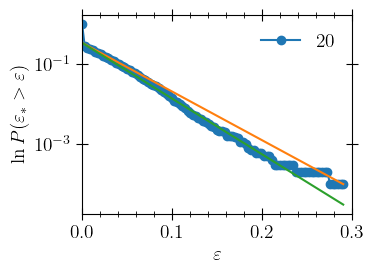

In [22]:
fig = figure(figsize=(3.6, 2.6))
ax = subplot(111)
ax.semilogy(tail_bins[1:end-1], tails[1:end-1] , "-o", label=string(N))
ax.semilogy(tail_bins[1:end-1], map(x -> exp.(-2*pi*sqrt(N)*x + m(0, tail_fit.param)) , tail_bins[1:end-1]))
ax.semilogy(tail_bins[1:end-1], map(x -> exp.(m(x, tail_fit.param)), tail_bins[1:end-1]))
legend()
# ax.set_yscale("log")
ax.set_xlim(0, 0.3)
# ax.set_ylim(1e-4, 1e0)
ax.set_xlabel("\$  \\varepsilon \$")
ax.set_ylabel("\$ \\ln P(\\varepsilon_* > \\varepsilon) \$")
tight_layout(pad=0.15, w_pad=0.0, h_pad=0.0)

In [23]:
N_range = 5:20;

In [24]:
all_tail_counts = Dict()
all_tail_bins = Dict()
for N in N_range
    new_file = "SK_model_" * "p_" * string(p) * "_N_" * string(N) * "_num_inst_" * string(num_instances) * "_seed_" * string(seed) * "_hist_stats.h5"
    data_file = h5open(PATH * new_file, "r")
    all_E_stars = read(data_file, "all_E_stars")

    new_file = "SK_model" * "_N_" * string(N) * "_num_inst_" * string(num_instances) * "_seed_" * string(seed) * "_exact.h5"
    data_file = h5open(PATH * new_file, "r")
    all_E_0s = []
    for i in 1:num_instances
        E_0 = read(data_file, "set_" * string(i) * "/E_0")
        push!(all_E_0s, E_0)
    end

    tail_counts, tail_bins = np.histogram((all_E_stars .- all_E_0s) ./ abs(mean(all_E_0s)), bins=100)
    tail_bins[1] = 1e-10
    all_tail_counts[N] = tail_counts
    all_tail_bins[N] = tail_bins
end

Ansatz:
$$
\sim\exp\left\{-f(N)\varepsilon + c\right\}
$$

In [25]:
cutoff = 0.1;

In [26]:
all_tails = Dict()
all_tail_fits = Dict()
all_tail_ycuts = Dict()
for N in N_range
    tails = []
    for i in 1:size(all_tail_bins[N])[1]
        push!(tails, sum(all_tail_counts[N][i:end]) ./ num_instances)
    end
    all_tails[N] = tails .+ 1e-15
    cutoff_idx = findfirst(y -> y == argmin(x -> abs.(x .- cutoff), all_tail_bins[N]), all_tail_bins[N])
    tail_fit = curve_fit(m, all_tail_bins[N][2:end-cutoff_idx], log.(all_tails[N][2:end-cutoff_idx]), [1., -10])
    all_tail_ycuts[N] = tail_fit.param[1] 
    all_tail_fits[N] = tail_fit.param[2]  
end

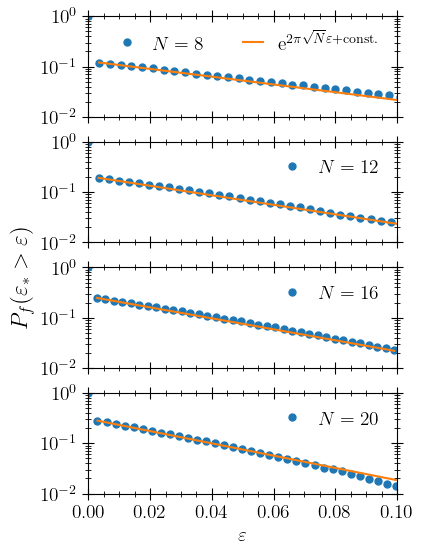

In [27]:
fig = figure(figsize=(4.2, 5.5))

styles = ["-o", "-s", "-^", "-v"]
styles = ["o" for _ in 1:size(N_range)[1]]
# for (k, N) in enumerate([5, 10, 15, 20])
for (k, N) in enumerate([8, 12, 16, 20])
    ax = subplot(4, 1, k)
    cutoff_idx = findfirst(y -> y == argmin(x -> abs.(x .- cutoff), all_tail_bins[N]), all_tail_bins[N])
    
    ax.semilogy(all_tail_bins[N][1:cutoff_idx], all_tails[N][1:cutoff_idx] , styles[k], label=@sprintf("\$N=%2d\$", N), ms=5)
    if k == 1
        ax.semilogy(all_tail_bins[N][2:cutoff_idx], map(x -> exp(-2pi*sqrt(N) * x + 2pi * sqrt(N) * all_tail_bins[N][2] + log(all_tails[N][2])), all_tail_bins[N][2:cutoff_idx]), 
            label="\$\\mathrm{e}^{2\\pi\\sqrt{N}\\varepsilon+\\mathrm{const.}}\$")
    else
        ax.semilogy(all_tail_bins[N][2:cutoff_idx], map(x -> exp(-2pi*sqrt(N) * x + 2pi * sqrt(N) * all_tail_bins[N][2] + log(all_tails[N][2])), all_tail_bins[N][2:cutoff_idx]))
    end    
    ax.set_xlim(0, 0.1)
    ax.set_ylim(1e-2, 1e0)

    if k < 4
        ax.set_xticklabels([])
    else
        ax.set_xlabel("\$  \\varepsilon \$")
    end
    legend(loc="upper right", ncol=2, handlelength=1.0)
    fig.supylabel("\$ P_f(\\varepsilon_* > \\varepsilon) \$")
end

tight_layout(pad=0.4)
savefig(PATH_DB * "Fig4.pdf", dpi=300)

### Fluctuations

#### Easy instance

In [2]:
PATH_DB = "/home/lappet/Dropbox/MidnightRambler/Mean_Field_AOA/Figures/Data/SK_model/Easy_Instance_N11/"
FILE = "Easy_instance_SK_model_seed_61_N_11_tau_05_p_1000.h5"
filename = PATH_DB * FILE
h5file = h5open(filename, "r")
E_0 = read(h5file, "E0")
J = read(h5file, "J_ij")
exact_levels = read(h5file, "Levels")
mf_level = read(h5file, "MF_Energy-E0")
lyapunov = read(h5file, "Lyapunov_Exp");
# omega = read(h5file, "omega_n");

In [3]:
times = np.linspace(0, 1, size(E_0)[1]);
times_medium = np.linspace(0, 1, size(lyapunov)[1]);

No handles with labels found to put in legend.


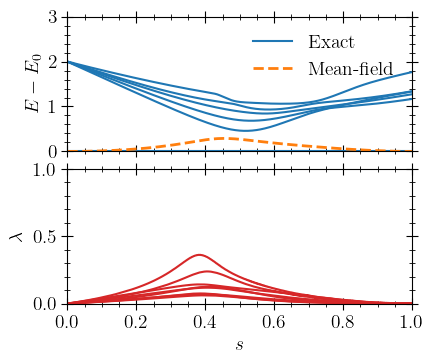

In [4]:
fig = figure(figsize=(4.2,  3.5))
ax = subplot(211)
for k in 1:6
    if k == 1
        ax.plot(times, exact_levels[:, k], "-C0", label="Exact")
    else
        ax.plot(times, exact_levels[:, k], "-C0")
    end
end

ax.plot(times, mf_level, "--C1", lw=2, label="Mean-field")
ax.set_ylabel("\$ E - E_0 \$")
ax.set_xticklabels([])
ax.set_xlim(0, 1)
ax.set_ylim(0, 3)
ax.legend(loc="upper right")

ax = subplot(212)
map(D -> ax.plot(times_medium, D, "-C3"), [lyapunov[:, k] for k in 1:8])
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.5, 1])
ax.set_xlabel("\$s\$")
ax.set_ylabel("\$ \\lambda \$")
ax.legend(ncol=2, columnspacing=0.1)

tight_layout(pad=0.15, w_pad=0.0, h_pad=0.0)
# savefig(PATH_DB * "Fig7.pdf", dpi=300)

#### Hard instance

In [5]:
PATH_DB = "/home/lappet/Dropbox/MidnightRambler/Mean_Field_AOA/Figures/Data/SK_model/Hard_Instance_N11/"
FILE = "Hard_instance_SK_model_seed_2041_N_11_tau_05_p_5000.h5"
filename = PATH_DB * FILE
h5file = h5open(filename, "r")
E_0 = read(h5file, "E0")
J = read(h5file, "J_ij")
exact_levels_hard = read(h5file, "Levels")
mf_level_hard = read(h5file, "MF_Energy-E0")
lyapunov_hard = read(h5file, "Lyapunov_Exp")
omega_hard = read(h5file, "omega_n");

In [6]:
times_long = np.linspace(0, 1, size(lyapunov_hard)[1]);

In [7]:
using Base.Iterators
styles = cycle(["-", "--", "-.", ":"]);

No handles with labels found to put in legend.


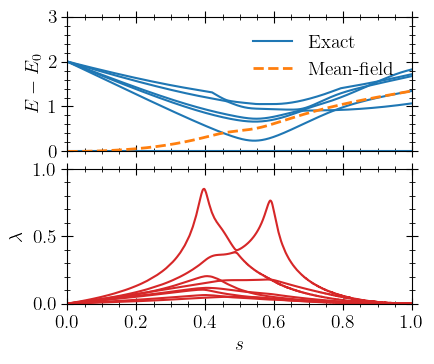

In [8]:
fig = figure(figsize=(4.2,  3.5))
ax = subplot(211)
for k in 1:6
    if k == 1
        ax.plot(times, exact_levels_hard[:, k], "-C0", label="Exact")
    else
        ax.plot(times, exact_levels_hard[:, k], "-C0")
    end
end

ax.plot(times, mf_level_hard, "--C1", lw=2, label="Mean-field")

# for k in 1:3
#     if k == 1
#         ax.plot(times, omega_hard[:, k], ":C2", alpha=0.6, lw=2, label="Paramagnons")
#     else
#         ax.plot(times, omega_hard[:, k], ":C2", alpha=0.6, lw=2)
#     end
# end

ax.set_ylabel("\$ E - E_0 \$")
ax.set_xticklabels([])
ax.set_xlim(0, 1)
ax.set_ylim(0, 3)
# ax.legend(ncol=2, columnspacing=-1.4, handlelength=1.3)
ax.legend(loc="upper right")

ax = subplot(212)
for (k, style) in enumerate(collect(take(styles, 8)))
    ax.plot(times_long, lyapunov_hard[:, k], c="C3")#, ls=style)
end
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.5, 1])
ax.set_xlabel("\$s\$")
ax.set_ylabel("\$ \\lambda \$")
ax.legend(ncol=1, columnspacing=0.1)

tight_layout(pad=0.15, w_pad=0.0, h_pad=0.0)
# savefig(PATH_DB * "Fig8.pdf", dpi=300)

#### Combined Plot

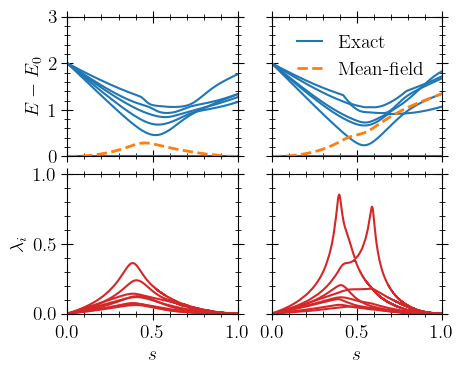

In [9]:
fig = figure(figsize=(4.5,  3.6))
ax = subplot(221)
for k in 1:6
    if k == 1
        ax.plot(times, exact_levels[:, k], "-C0", label="Exact")
    else
        ax.plot(times, exact_levels[:, k], "-C0")
    end
end

ax.plot(times, mf_level, "--C1", lw=2, label="Mean-field")
ax.set_ylabel("\$ E - E_0 \$")
ax.set_xticklabels([])
ax.set_xlim(0, 1)
ax.set_ylim(0, 3)
# ax.legend(loc="upper right")

ax = subplot(223)
map(D -> ax.plot(times_medium, D, "-C3"), [lyapunov[:, k] for k in 1:8])
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.5, 1])
ax.set_xlabel("\$s\$")
ax.set_ylabel("\$ \\lambda_i \$")

# =================================================

ax = subplot(222)
for k in 1:6
    if k == 1
        ax.plot(times, exact_levels_hard[:, k], "-C0", label="Exact")
    else
        ax.plot(times, exact_levels_hard[:, k], "-C0")
    end
end

ax.plot(times, mf_level_hard, "--C1", lw=2, label="Mean-field")

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlim(0, 1)
ax.set_ylim(0, 3)
# ax.legend(ncol=2, columnspacing=-1.4, handlelength=1.3)
ax.legend(loc="upper right", handlelength=1.3)

ax = subplot(224)
for (k, style) in enumerate(collect(take(styles, 8)))
    ax.plot(times_long, lyapunov_hard[:, k], c="C3")#, ls=style)
end
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels([])
ax.set_xlabel("\$s\$")

tight_layout(pad=0.15, w_pad=0.5, h_pad=0.0)
# savefig("/home/lappet/Dropbox/MidnightRambler/Mean_Field_AOA/Figures/Data/SK_model/" * "Fig7.pdf", dpi=300)

#### Hard instance (large)

In [26]:
PATH_DB = "/home/lappet/Dropbox/MidnightRambler/Mean_Field_AOA/Figures/Data/SK_model/Hard_Instance_N18/"
FILE = "Hard_instance_SK_model_N_18_tau_05_p_5000.h5"
filename = PATH_DB * FILE
h5file = h5open(filename, "r")
# E_0 = read(h5file, "E0")
# J = read(h5file, "J_ij")
# exact_levels_hard_18 = read(h5file, "Levels")
# mf_level_hard_18 = read(h5file, "MF_Energy-E0")
lyapunov_hard_18_5000 = read(h5file, "Lyapunov_Exp")
omega_hard_18 = read(h5file, "omega_n");

In [27]:
PATH_DB = "/home/lappet/Dropbox/MidnightRambler/Mean_Field_AOA/Figures/Data/SK_model/Hard_Instance_N18/"
FILE = "Hard_instance_SK_model_N_18_tau_05_p_20000.h5"
filename = PATH_DB * FILE
h5file = h5open(filename, "r")
# E_0 = read(h5file, "E0")
# J = read(h5file, "J_ij")
exact_levels_hard_18 = read(h5file, "Levels")
mf_level_hard_18 = read(h5file, "MF_Energy-E0")
lyapunov_hard_18 = read(h5file, "Lyapunov_Exp")
omega_hard_18 = read(h5file, "omega_n");

In [28]:
PATH_DB = "/home/lappet/Dropbox/MidnightRambler/Mean_Field_AOA/Figures/Data/SK_model/Hard_Instance_N33/"
FILE = "Hard_instance_SK_model_N_33_tau_04_p_20000.h5"
filename = PATH_DB * FILE
h5file = h5open(filename, "r")
# E_0 = read(h5file, "E0")
# J = read(h5file, "J_ij")
# exact_levels_hard_33 = read(h5file, "Levels")
# mf_level_hard_33 = read(h5file, "MF_Energy-E0")
lyapunov_hard_33 = read(h5file, "Lyapunov_Exp")
omega_hard_33 = read(h5file, "omega_n");

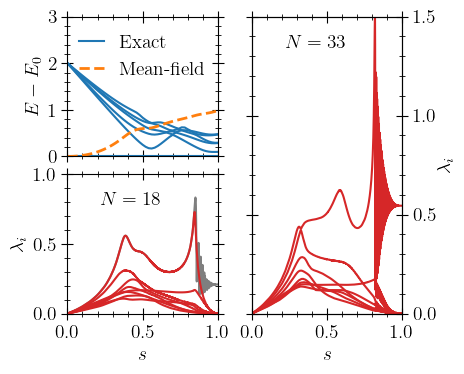

In [156]:
# fig = figure(figsize=(5,  4))
fig = figure(figsize=(4.5,  3.6))
grid = PyPlot.plt.GridSpec(2, 2)#, wspace=0.15, hspace=0.15)

ax = subplot(get(grid, (0, 0)))
times = np.linspace(0, 1, size(mf_level_hard_18)[1]);
times_long = np.linspace(0, 1, size(lyapunov_hard_18)[1]);

for k in 1:6
    if k == 1
        ax.plot(times, exact_levels_hard_18[:, k], "-C0", label="Exact")
    else
        ax.plot(times, exact_levels_hard_18[:, k], "-C0")
    end
end

ax.plot(times, mf_level_hard_18, "--C1", lw=2, label="Mean-field")
ax.set_ylabel("\$ E - E_0 \$")
ax.set_xticklabels([])
ax.set_xlim(0, 1)
ax.set_ylim(0, 3)
ax.legend(loc="upper center", handlelength=1.25)

# subplot(get(grid, (0, 1)))

ax = subplot(get(grid, (1, 0)))

map(D -> ax.plot(np.linspace(0, 1, size(lyapunov_hard_18_5000)[1]), D, "-C7"), [lyapunov_hard_18_5000[:, k] for k in 1:1])
map(D -> ax.plot(times_long, D, "-C3"), [lyapunov_hard_18[:, k] for k in 1:8])
ax.plot([], [], label="\$N = 18\$", lw=0)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.5, 1])
ax.set_xlabel("\$s\$")
ax.set_ylabel("\$ \\lambda_i \$")
ax.legend(loc="upper left", handlelength=0)


ax = subplot(get(grid, (pycall(pybuiltin("slice"), PyObject, 0, 2), 1)))
for (k, style) in enumerate(collect(take(styles, 8)))
    ax.plot(times_long, lyapunov_hard_33[:, k], c="C3")#, ls=style)
end
ax.plot([], [], label="\$N = 33\$", lw=0)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1.5)
ax.set_yticks([k * 0.5 for k in 0:3])
ax.set_xlabel("\$s\$")
ax.set_ylabel("\$ \\lambda_i \$", labelpad=25)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax2 = ax.twinx()
ax2.set_ylim(0, 1.5)
ax2.set_yticks([k * 0.5 for k in 0:3])
ax.set_yticklabels([])
ax.legend(loc="upper left", handlelength=0)

tight_layout(pad=0.15, w_pad=0.5, h_pad=0.0)
savefig("/home/lappet/Dropbox/MidnightRambler/Mean_Field_AOA/Figures/Data/SK_model/" * "Fig8.pdf", dpi=300)

## Testing

In [ ]:
fig = figure(figsize=(4.5, 3))

styles = ["o", "s", "^", "v"]
styles = ["^", "o", "s", "v"]
# styles = ["o" for _ in 1:size(N_range)[1]]
ax = subplot(111)
for (k, N) in enumerate([10, 15, 20])
# for (k, N) in enumerate([8, 12, 16, 20])
#     ax = subplot(4, 1, k)
    cutoff_idx = findfirst(y -> y == argmin(x -> abs.(x .- cutoff), all_tail_bins[N]), all_tail_bins[N])
    
    if k == 1
        ax.semilogy(sqrt(N) .* all_tail_bins[N][2:cutoff_idx], map(x -> exp(-2pi*x + 2pi * sqrt(N) * all_tail_bins[N][2] + log(all_tails[N][2])), sqrt(N) .* all_tail_bins[N][2:cutoff_idx]), 
            label="\$\\mathrm{e}^{2\\pi\\sqrt{N}\\varepsilon}\$", "-k")
    else
        ax.semilogy(sqrt(N) .* all_tail_bins[N][2:cutoff_idx], map(x -> exp(-2pi*x + 2pi * sqrt(N) * all_tail_bins[N][2] + log(all_tails[N][2])), sqrt(N) .* all_tail_bins[N][2:cutoff_idx]), 
            "-k")
    end     
    
    ax.semilogy(sqrt(N) .* all_tail_bins[N][1:cutoff_idx], all_tails[N][1:cutoff_idx] , styles[k], label=@sprintf("\$N=%2d\$", N), ms=5)
   
end
ax.set_xlim(0, 0.4)
# ax.set_ylim(1e-2, 1e0)
ax.set_ylim(1e-2, 3e-1)
ax.set_xlabel("\$  \\sqrt{N}\\varepsilon \$")
ax.set_ylabel("\$ P_f(\\varepsilon_* > \\varepsilon) \$")
legend(loc="lower left", ncol=1, handlelength=1.0)

tight_layout(pad=0.4)
savefig(PATH_DB * "Fig4.pdf", dpi=300)

In [ ]:
fig = figure(figsize=(4.2, 3))

styles = ["-o", "-s", "-^", "-v"]
styles = ["o" for _ in 1:size(N_range)[1]]
ax = subplot(111)
# for (k, N) in enumerate([5, 10, 15, 20])
for (k, N) in enumerate([8, 12, 16, 20])
# for (k, N) in enumerate([17, 18, 19, 20])        
# for (k, N) in enumerate([20])
    cutoff_idx = findfirst(y -> y == argmin(x -> abs.(x .- cutoff), all_tail_bins[N]), all_tail_bins[N])
    ax.semilogy(all_tail_bins[N][2:cutoff_idx], all_tails[N][2:cutoff_idx] , styles[k], label=string(N), ms=4)
    ax.semilogy(all_tail_bins[N][2:cutoff_idx], map(x -> exp(-2pi*sqrt(N) * x + 2pi * sqrt(N) * all_tail_bins[N][2] + log(all_tails[N][2])), all_tail_bins[N][2:cutoff_idx]) , c="C"*string(k-1))
    ax.set_xlim(0, cutoff)
    ax.set_ylim(1e-2, 1e0)
    legend(loc="upper right", ncol=2)
end

tight_layout(pad=0.15, w_pad=0.0, h_pad=0.5)

In [ ]:
fig = figure(figsize=(15, 3))

styles = ["-o", "-s", "-^", "-v"]
styles = ["o" for _ in 1:size(N_range)[1]]
# for (k, N) in enumerate([5, 10, 15, 20])
# for (k, N) in enumerate([5, 7, 11, 14])
for (k, N) in enumerate([9 + k for k in 0:3])        
    ax = subplot(1, 4, k)
    idx = findfirst(y -> y == argmin(x -> abs.(x .- cutoff), all_tail_bins[N]), all_tail_bins[N])
    ax.semilogy(all_tail_bins[N][1:idx], all_tails[N][1:idx] , styles[k], label=string(N), ms=4)
#     ax.semilogy(all_tail_bins[N][1:idx], map(x -> exp(-tail_scaling(N, tail_scaling_fit.param) * x + all_tail_ycuts[N]), all_tail_bins[N][1:idx]))
    ax.semilogy(all_tail_bins[N][1:idx], map(x -> exp(all_tail_fits[N] * x + all_tail_ycuts[N]), all_tail_bins[N][1:idx]))
    ax.semilogy(all_tail_bins[N][1:idx], map(x -> exp(-2pi*sqrt(N) * x + all_tail_ycuts[N]), all_tail_bins[N][1:idx]), label="\$2\\pi\\sqrt{N}\$")
    ax.set_xlim(0, 0.12)
    legend(loc="upper right", ncol=2)
end


tight_layout(pad=0.15, w_pad=0.0, h_pad=0.5)